## Data and Package Importing

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from QC import *
sc.settings.set_figure_params(dpi=100)

/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Load data and preprocess

In [2]:
adata = sc.read_h5ad("s1_raw.h5ad")

In [3]:
reorder_AnnData(adata) #quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
adata #this also calculates the n_counts value, which is the total number of counts per cell/barcode

AnnData object with n_obs × n_vars = 13716 × 80009 
    obs: 'n_counts'

In [4]:
adata.raw = adata #checkpoint before normalizing and scaling data

In [8]:
#create new "observation" as percent mito and mean mito
mito_genes = adata.var_names.str.startswith('mt-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / adata.obs['n_counts']
adata.obs['mean_mito'] = np.mean(adata[:, mito_genes].X, axis=1)

In [9]:
#create new "observation" as percent hematopoietic and mean hematopoietic
hematopoietic_genes = adata.var_names.str.contains('Hbb-bs$|Cd14$|Jchain$|NAGK$')
adata.obs['percent_hematopoietic'] = np.sum(adata[:, hematopoietic_genes].X, axis=1) / adata.obs['n_counts']
adata.obs['mean_hematopoietic'] = np.mean(adata[:, hematopoietic_genes].X, axis=1)

#It's important to examine multiple methods of compiling genes into a single meta-feature, as percents may be biased towards the number of genes used in the summation while means may be thrown off by outliers.

### Find inflection point

Inflection point at index
bcDZZU     4627
bcBTQF     3644
bcAGFS     6859
bcHRFF    13715
Name: n_counts, dtype: int64 for [0, 15, 30, 100] percentiles of greatest secant distances


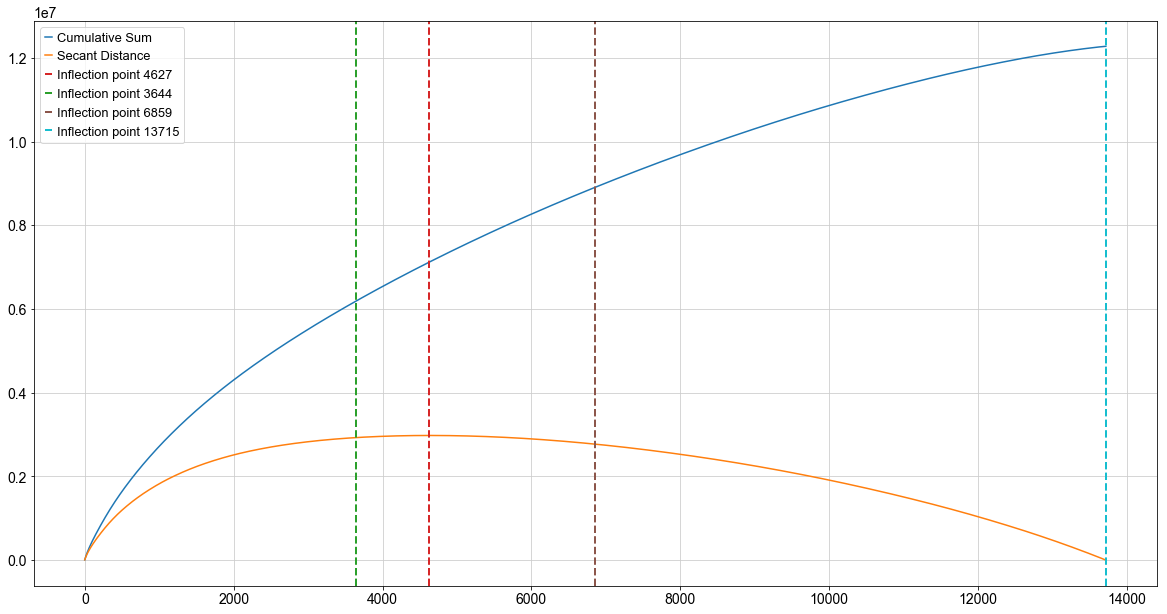

In [10]:
find_inflection(adata)

In [11]:
#filter cells out based on minimum quality
sc.pp.filter_cells(adata,min_counts=adata.obs.iloc[4627].n_counts)

In [12]:
adata

AnnData object with n_obs × n_vars = 4628 × 80009 
    obs: 'n_counts', 'percent_hematopoietic', 'mean_hematopoietic', 'percent_mito', 'mean_mito'

In [13]:
adata.obs['ranked_n_counts'] = np.argsort(adata.obs['n_counts']) 

### Normalize and perform linear dimensionality reduction with PCA

In [14]:
sc.pp.normalize_total(adata) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata) #log1p normalization

In [15]:
#same as above but wrapped up in one function and utilizes the arcsinh transform instead of log1p, commented out for convenience
#arcsinh_transform(adata)

In [16]:
adata

AnnData object with n_obs × n_vars = 4628 × 80009 
    obs: 'n_counts', 'percent_hematopoietic', 'mean_hematopoietic', 'percent_mito', 'mean_mito', 'ranked_n_counts'

In [17]:
sc.pp.scale(adata) #scaling by variance and centering to zero for visualization
sc.tl.pca(adata) #performing PCA

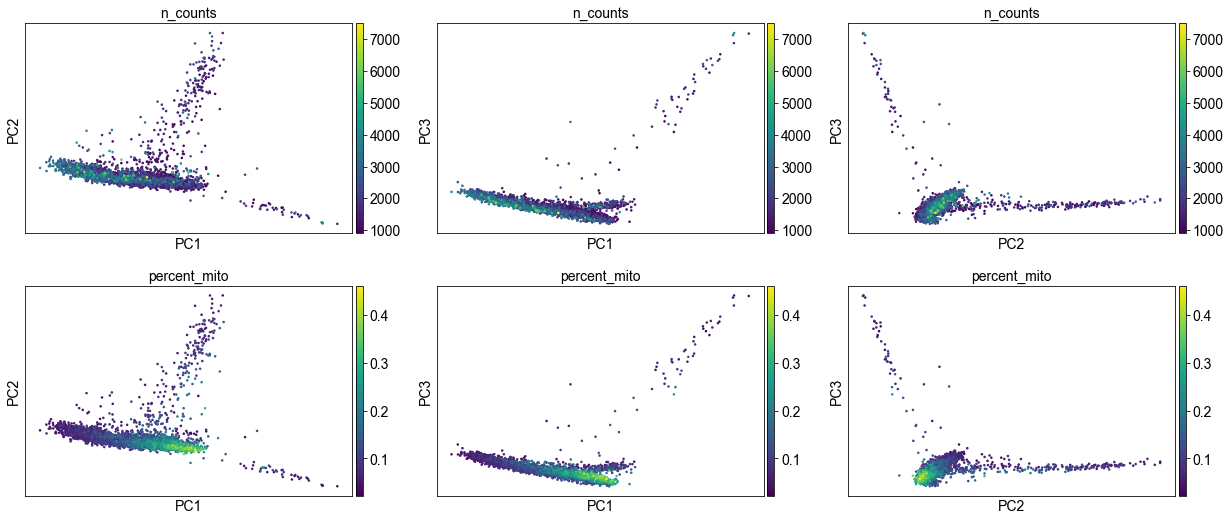

In [18]:
sc.pl.pca(adata, color=['n_counts','percent_mito'],components=['1,2','1,3','2,3'],ncols=3)

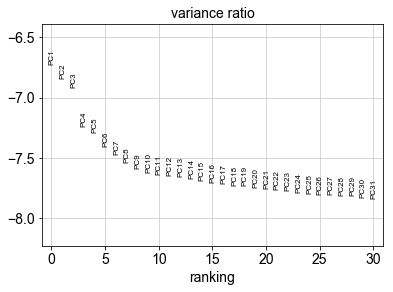

In [19]:
sc.pl.pca_variance_ratio(adata, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [20]:
sc.pp.neighbors(adata,n_neighbors=30, n_pcs=20) #UMAP requires this neighborhood calculation first, will give deprecation warnings

/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages

In [21]:
sc.tl.umap(adata) #perform UMAP

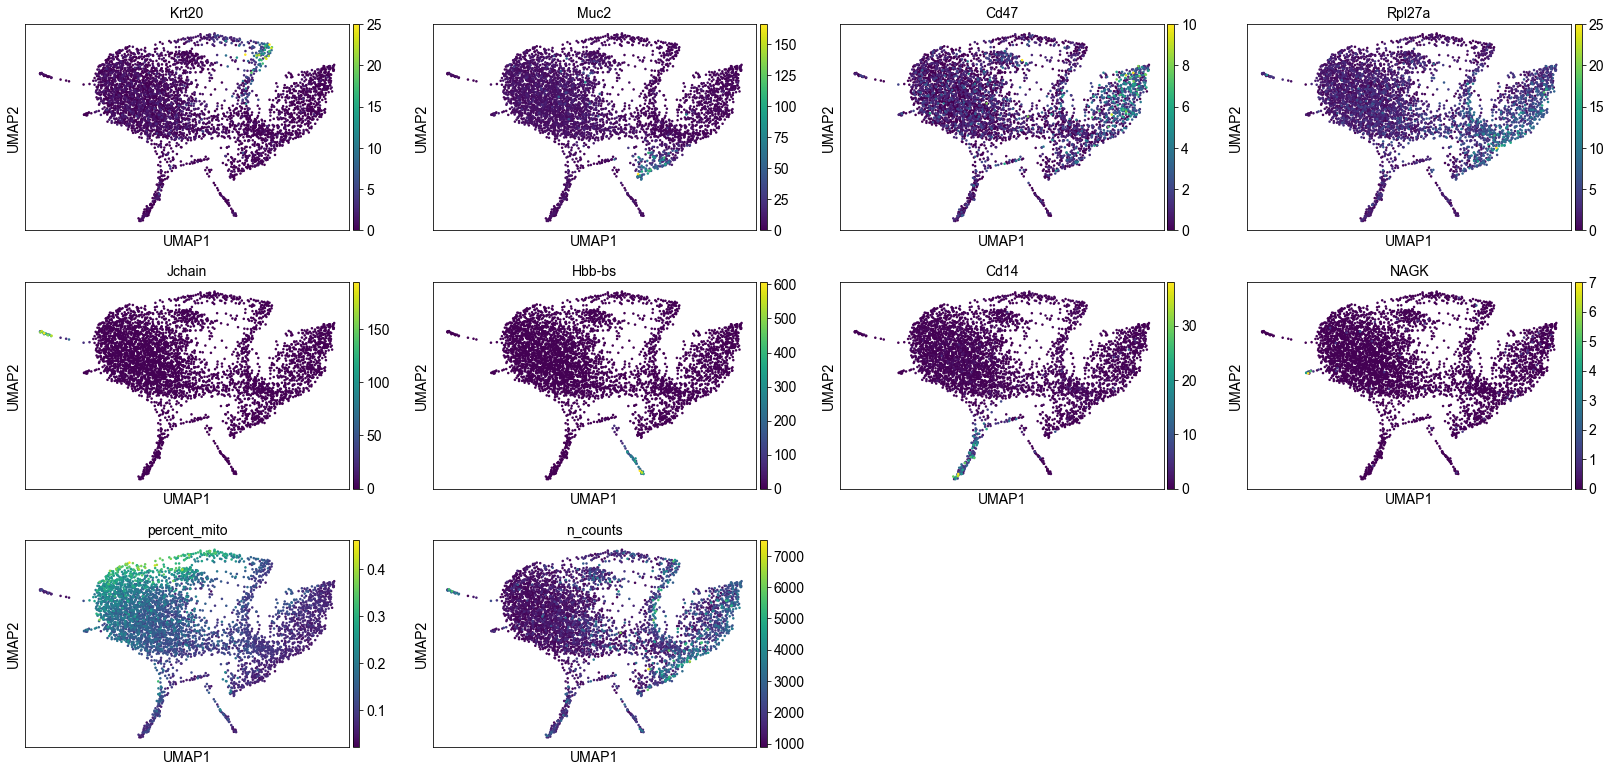

In [22]:
sc.pl.umap(adata,color=['Krt20','Muc2','Cd47','Rpl27a','Jchain','Hbb-bs','Cd14','NAGK','percent_mito','n_counts']) #plot marker genes to determine which clusters to keep or gate out

### Clustering

In [23]:
sc.tl.louvain(adata,resolution=1.6) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

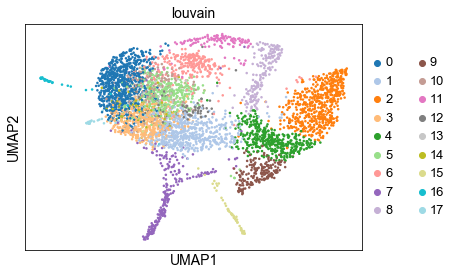

In [24]:
sc.pl.umap(adata, color=['louvain'],wspace=0.5,palette='tab20')

### Cluster quantification and non-parametric testing of gene expression profiles for gating

In [25]:
cluster_summary_stats(adata,raw=False) #in this case it's after normalization, but if you want to find these statistics for the raw counts, set the raw parameter to True

In [26]:
cluster_wilcoxon_rank_sum(adata,['Krt20','Muc2','Jchain','percent_mito','mean_mito','percent_hematopoietic','mean_hematopoietic'],alternative='greater') 
#this takes a list of features that exist in the normalized representation of the data and performs a wilcoxon rank sum test between each cluster against the global counterparts of those data.
#these features can be single genes or compiled 'metagenes' such as the percent_mito and the mean_mito, as long as their values can be accessed in the AnnData object by using the .obs_vector method
#the "alternative" parameter is passed to scipy's "mann-whitney u" to desgnate the sidedness of the test, in this case the default is a one-sided hypothesis for values greater than the null.

In [27]:
cluster_p_threshold(adata,0.05)
#this takes the p-values calculated above (per cluster) and simply returns a binarized output (0 or 1) that can be visualized
#the output represents wether or not the cluster has a p-value below the set threshold (0.05 in this case) 

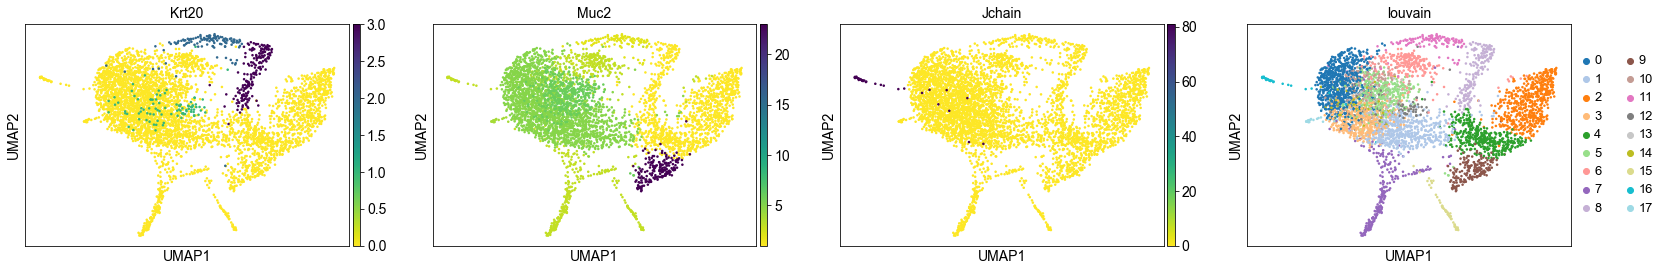

In [28]:
sc.pl.umap(adata,color=['Krt20','Muc2','Jchain','louvain'],color_map='viridis_r',layer='Cluster_Medians') #Cluster medians per feature

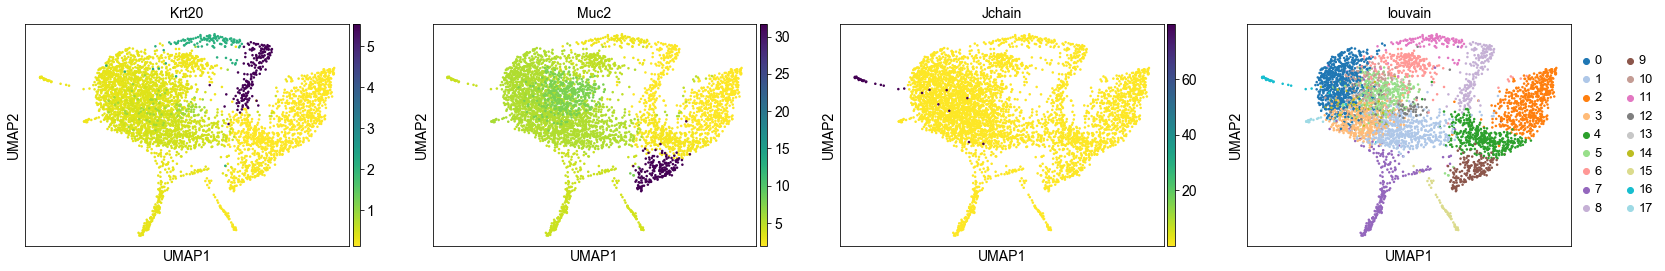

In [29]:
sc.pl.umap(adata,color=['Krt20','Muc2','Jchain','louvain'],color_map='viridis_r',layer='Cluster_Means') #Cluster means per feature≤

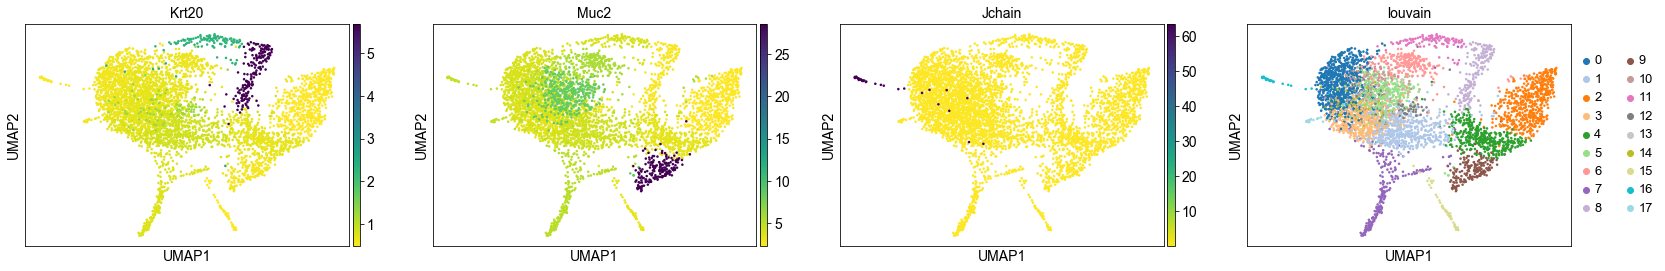

In [30]:
sc.pl.umap(adata,color=['Krt20','Muc2','Jchain','louvain'],color_map='viridis_r',layer='Cluster_Stdevs') #Cluster stdevs per feature

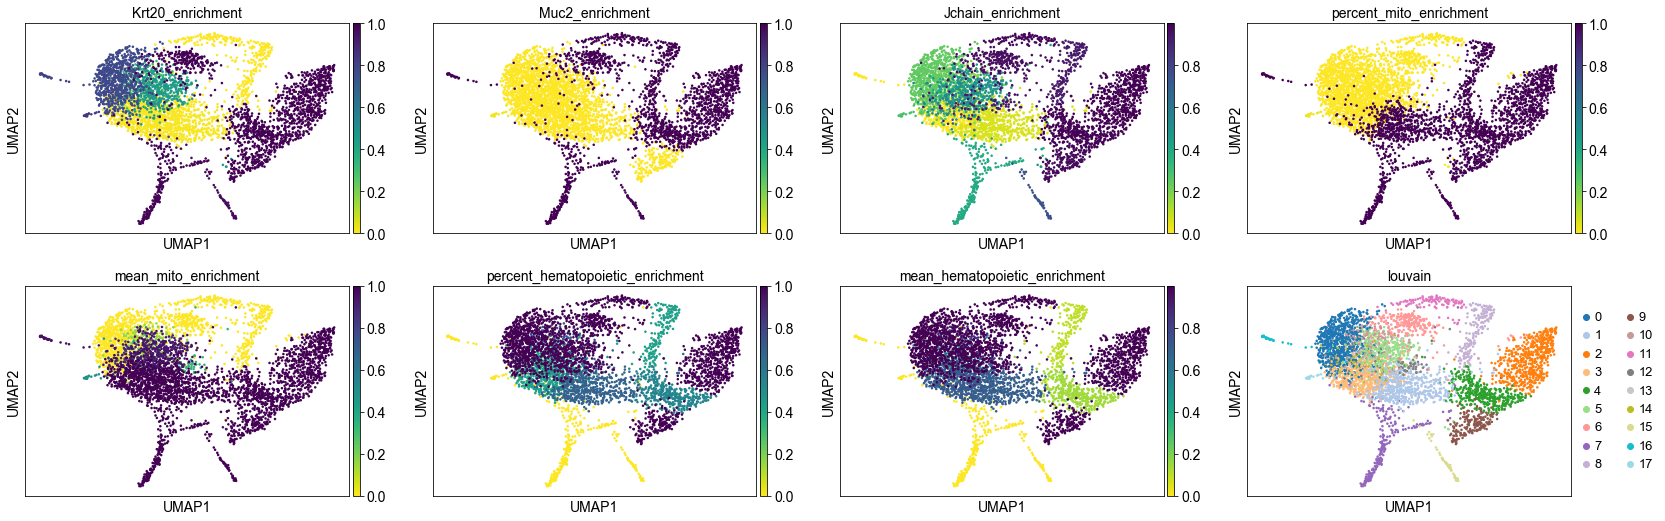

In [31]:
sc.pl.umap(adata,color=['Krt20_enrichment','Muc2_enrichment','Jchain_enrichment',
                        'percent_mito_enrichment','mean_mito_enrichment','percent_hematopoietic_enrichment','mean_hematopoietic_enrichment','louvain'],color_map='viridis_r')
#these are simply the p-values resulting from the features/featuresets tested, this visualization just shows a continuum of p-values per cluster given that test

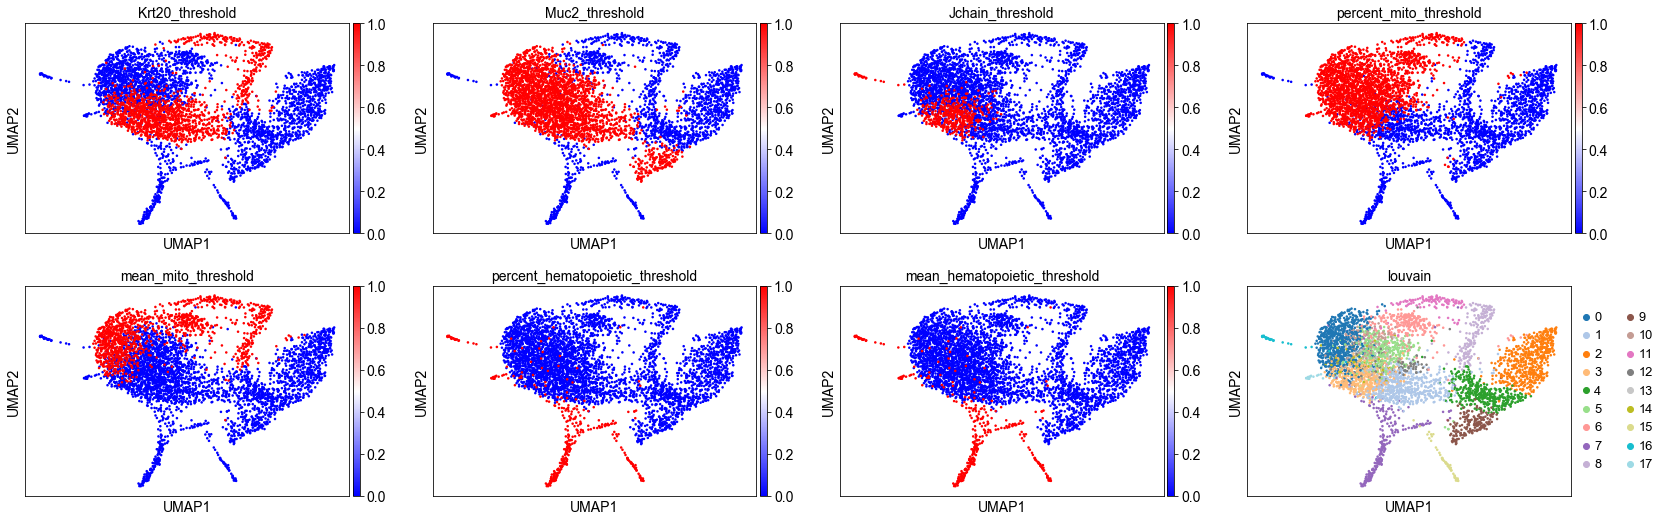

In [32]:
sc.pl.umap(adata,color=['Krt20_threshold','Muc2_threshold','Jchain_threshold',
                        'percent_mito_threshold','mean_mito_threshold','percent_hematopoietic_threshold','mean_hematopoietic_threshold','louvain'],color_map = 'bwr')
#similar to above, but with significance threholded at 0.05 as per the example, this gives us a better idea of which louvain clusters to gate out based off of statistical bases

In [34]:
#the above overlays are simply to guide the louvain cluster gating process by providing more quantitative and statistically robust methods for determining which clusters to gate out  

In [35]:
to_keep = np.where(adata.obs['louvain'].isin(['2','4','7','8']))[0] #fill in the indices of the clusters you want to keep here
#we choose these to keep because all other clusters have a significant enrichment for mitochondrial genes or hematopoetic cells

In [58]:
adata_filtered = sc.AnnData(adata.raw.X[to_keep,:]) #subsetting the original data to make a filtered dataset, here, we subset the raw (.raw) count data for our new object/QC'd dataset
adata_filtered.obs = pd.DataFrame(adata.obs.iloc[to_keep,:]['n_counts']) #subsetting the original data to make a filtered dataset
adata_filtered.var = adata.var #transferring variable/feature names 

In [59]:
adata_filtered #quick check of reduced/filtered dataset properties
#note that this example does NOT transfer over the calculated observations (though possible), this is simply to simplify the object for downstream analysis, a "fresh start" in a way
#this object simply contains a subset of cells and their gene counts given the starting dataset with no further calculated features outside of n_counts

AnnData object with n_obs × n_vars = 1396 × 80009 
    obs: 'n_counts'

In [61]:
adata_filtered.write_h5ad("s1_filtered.h5ad",compression='gzip') #optional saving results to file as compressed .h5ad 